In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
import random
import matplotlib.pyplot as plt
from datetime import datetime

In [ ]:
#Select 5 Companies of each Sector as they tend to have different behaviorss
sp500 = pd.read_csv('../CSV/List_SP500_Wiki.csv')

# Define the number of random rows to select for each category
num_rows = 5

# Get unique categories in the 'GICS Sector' column
categories = sp500['GICS Sector'].unique()

# Initialize an empty DataFrame to store the selected rows
selected_rows = pd.DataFrame()

# Select random rows for each category
for category in categories:
    category_rows = sp500[sp500['GICS Sector'] == category]
    random_rows = category_rows.sample(n=min(num_rows, len(category_rows)), random_state=20)
    selected_rows = pd.concat([selected_rows, random_rows])

symbols = selected_rows['Symbol']

tickers = " ".join(symbols)

In [4]:
# Load Oil Prices
oil = yf.download('CL=F', start='2010-01-01', end='2023-05-22')
oil = oil.reset_index()
oil = oil[['Date', 'Adj Close']]
oil.rename(columns={'Adj Close' : 'Oil price'}, inplace=True)
print(oil.tail())

# Load Gold Prices
gold = yf.download('GC=F', start='2010-01-01', end='2023-05-22')
gold = gold.reset_index()
gold = gold[['Date', 'Adj Close']]
gold.rename(columns={'Adj Close' : 'Gold price'}, inplace=True)
print(gold.tail())
merged_oil_gold = oil.merge(gold, on='Date', how='inner')
merged_oil_gold.tail()


[*********************100%***********************]  1 of 1 completed
           Date  Oil price
3364 2023-05-15  71.110001
3365 2023-05-16  70.860001
3366 2023-05-17  72.830002
3367 2023-05-18  71.860001
3368 2023-05-19  71.550003
[*********************100%***********************]  1 of 1 completed
           Date   Gold price
3362 2023-05-15  2018.000000
3363 2023-05-16  1988.400024
3364 2023-05-17  1980.699951
3365 2023-05-18  1956.500000
3366 2023-05-19  1978.699951


,Date,Oil price,Gold price
3362,2023-05-15,71.110001,2018.000000
3363,2023-05-16,70.860001,1988.400024
3364,2023-05-17,72.830002,1980.699951
3365,2023-05-18,71.860001,1956.500000
3366,2023-05-19,71.550003,1978.699951


In [6]:
import matplotlib.pyplot as plt

def plot_time_series(df, date_column, column_name):
    # Convert the 'date_column' to datetime if it's not already
    df[date_column] = pd.to_datetime(df[date_column])
    
    # Sort the DataFrame by date
    df = df.sort_values(by=date_column)

    # Get all the unique symbols
    symbols = df['Symbol'].unique()

    plt.figure(figsize=(12, 6))

    for symbol in symbols:
        symbol_df = df[df['Symbol'] == symbol]
        plt.plot(symbol_df[date_column], symbol_df[column_name], label=symbol)

    plt.title(f'Time Series Plot of {column_name} for all symbols', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel(column_name, fontsize=14)
    plt.grid(True)
    plt.legend()
    plt.show()

def plot_log_diff(df, value_column):
    # Normalize the values
    scaler = MinMaxScaler()
    df[value_column] = scaler.fit_transform(df[value_column].values.reshape(-1, 1))
    
    # Calculate log differences
    df['Log Diff'] = np.log(df[value_column]) - np.log(df[value_column].shift(1))
    df = df.dropna()  # drop NaN values
    
    # Plot the log differences
    plt.figure(figsize=(12, 6))
    plt.plot(df['Log Diff'])
    plt.title('Log Differences of Normalized Values', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Log Differences', fontsize=14)
    plt.grid(True)
    plt.show()


In [6]:
random.seed(40)

tickers = pd.read_csv('../CSV/S&P500_opincome.csv')
tickers = [i for i in tickers['Symbol']]

tickers = random.sample(tickers, 5)
tickers = " ".join(tickers)

In [7]:
tickers

'HLT MTB TSCO JPM ALK'

In [12]:
ticker_data = yf.download(tickers, start='2010-01-01', end='2023-05-22')
df = ticker_data.reset_index()

[*********************100%***********************]  5 of 5 completed


In [13]:
df_prices = ticker_data['Adj Close'].reset_index()
df_prices = df_prices.melt(id_vars='Date', var_name='Symbol', value_name='Adj Close')

df_volume = ticker_data['Volume'].reset_index()
df_volume = df_volume.melt(id_vars='Date', var_name='Symbol', value_name='Volume')

df= df_prices.merge(df_volume, on=['Date', 'Symbol'], how='left')
df = df[['Date', 'Symbol', 'Adj Close', 'Volume']]
df['Symbol'] =df['Symbol'].astype(str)

In [138]:
# Use if single ticker
df = ticker_data.reset_index()

In [14]:
df = df.merge(merged_oil_gold, on='Date', how='left')

In [15]:
df

,Date,Symbol,Adj Close,Volume,Oil price,Gold price
0,2010-01-04,ALK,7.839310,1802400.0,81.510002,1117.699951
1,2010-01-05,ALK,8.268708,3052800.0,81.769997,1118.099976
2,2010-01-06,ALK,8.194520,2994000.0,83.180000,1135.900024
3,2010-01-07,ALK,8.151804,2887200.0,82.660004,1133.099976
4,2010-01-08,ALK,7.989937,2457600.0,82.750000,1138.199951
...,...,...,...,...,...,...
16835,2023-05-15,TSCO,230.414902,1384700.0,71.110001,2018.000000
16836,2023-05-16,TSCO,225.210083,1653400.0,70.860001,1988.400024
16837,2023-05-17,TSCO,223.826782,1286500.0,72.830002,1980.699951
16838,2023-05-18,TSCO,229.449570,1384900.0,71.860001,1956.500000


c:\Users\emili\anaconda3\envs\DeepLearning\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


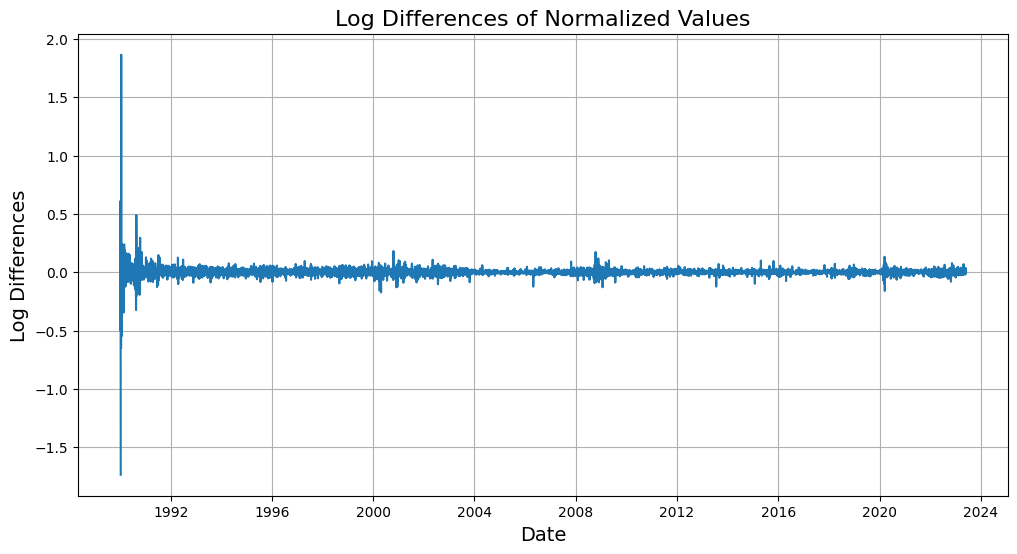

In [6]:
plot_log_diff(ticker_data, 'Adj Close')

In [16]:
plot_time_series(df, 'Date', 'Adj Close')

NameError: name 'plot_time_series' is not defined

In [23]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler

def preprocess_data(df, window_size):
    sequences = []
    target = []

    # Create Log Returns
    df.loc[:, 'Log Return'] = np.log(df['Adj Close']) - np.log(df['Adj Close'].shift(1))

    # Scale the Log Return values
    scaler_log_return = StandardScaler()
    df.loc[1:, 'Log Return'] = scaler_log_return.fit_transform(df['Log Return'].values.reshape(-1, 1)[1:])

    # Scale the Volume values
    scaler_volume = StandardScaler()
    df.loc[:, 'Volume'] = scaler_volume.fit_transform(df['Volume'].values.reshape(-1, 1))

    # Remove rows with NaN values
    df = df.iloc[1:]

    # Create sequences
    for symbol in df['Symbol'].unique():
        symbol_df = df[df['Symbol'] == symbol].copy()
        for i in range(len(symbol_df) - window_size):
            sequence = symbol_df[['Log Return', 'Volume']].iloc[i: i + window_size].values
            sequences.append(sequence)  # Append to the sequences list
            if i + window_size < len(symbol_df):  # Make sure we don't go out of bounds
                target.append(symbol_df['Log Return'].iloc[i + window_size])

    # Convert sequences and target to numpy arrays
    sequences = np.array(sequences)
    target = np.array(target)

    # Remove sequences with NaN values
    nan_sequence_mask = np.isnan(sequences).any(axis=(1, 2))
    sequences = sequences[~nan_sequence_mask]
    target = target[~nan_sequence_mask]

    return sequences, target, (scaler_log_return, scaler_volume)


def create_dataloader(sequences, target, batch_size):
    # Convert to PyTorch tensors
    sequences_tensor = torch.tensor(sequences).float()
    target_tensor = torch.tensor(target).float()

    # Create dataset and dataloader
    dataset = TensorDataset(sequences_tensor, target_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    return dataloader

def t2v(tau, f, w, b, w0, b0, arg=None):
    if arg:
        v1 = f(torch.matmul(tau, w) + b, arg)
    else:
        v1 = f(torch.matmul(tau, w) + b)
    v2 = torch.matmul(tau, w0) + b0
    return torch.cat([v1, v2], -1)

class SineActivation(nn.Module):
    def __init__(self, in_features, out_features):
        super(SineActivation, self).__init__()
        self.out_features = out_features
        self.w0 = nn.Parameter(torch.randn(in_features, 1))
        self.b0 = nn.Parameter(torch.randn(1))
        self.w = nn.Parameter(torch.randn(in_features, out_features-1))
        self.b = nn.Parameter(torch.randn(out_features-1))
        self.f = torch.sin

        # Apply Xavier initialization
        nn.init.xavier_uniform_(self.w0)
        nn.init.xavier_uniform_(self.w)
        

    def forward(self, tau):
        return t2v(tau, self.f, self.w, self.b, self.w0, self.b0)

class TransformerModel(nn.Module):
    def __init__(self, input_dim, output_dim, d_model, nhead, nhid, nlayers, dropout=0):
        super(TransformerModel, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.d_model = d_model
        self.t2v = SineActivation(2, input_dim)
        self.input_layer = nn.Sequential(
            nn.Linear(input_dim+2, d_model),   # Add 2 to the input size
            nn.LayerNorm(d_model)  # Add Layer Normalization
            )
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, nhid, dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, nlayers)
        self.fc = nn.Sequential(
            nn.Linear(d_model, 1024),
            nn.ReLU(),
            nn.LayerNorm(1024),
            nn.Linear(1024, 524),
            nn.LayerNorm(524),
            nn.ReLU(),
            nn.Linear(524, 100),
            nn.ReLU(),
            nn.LayerNorm(100),
            nn.Linear(100, 1)
        )
        
        # Apply Xavier initialization
        nn.init.xavier_uniform_(self.input_layer[0].weight)
        for layer in self.fc:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)

    def forward(self, src):
        t2v_output = self.t2v(src)  # Apply T2V
        src = torch.cat((src, t2v_output), dim=-1) # Concatenate along the last dimension
        src = self.input_layer(src)
        src = self.transformer_encoder(src)

        # Average across the sequence_length dimension
        src = src[:, -1, :]

        # Apply the fully connected network to the final output of the transformer encoder
        output = self.fc(src)
        return output.squeeze()

def train_model(dataloader, model, criterion, optimizer, device):
    model.train()
    total_loss = 0.

    for sequences, target in dataloader:
        sequences = sequences.to(device)
        target = target.to(device)
        
        # Change how the target tensor is reshaped
        target = target.reshape(-1)
        
        optimizer.zero_grad()
        output = model(sequences)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

def save_model(model, path):
    torch.save(model.state_dict(), path)

# Hyperparameters
window_size = 30
batch_size = 250
n_epochs = 10

# Preprocess data
sequences, target, scaler = preprocess_data(df, window_size)

# Create dataloader
dataloader = create_dataloader(sequences, target, batch_size)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def custom_mse_loss(output, target):
    return torch.mean((output - target) ** 2)

# Define model, criterion, and optimizer
model = TransformerModel(d_model=480, input_dim=2, output_dim=1, nhead=10, nhid=1024, nlayers=24).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=.0001)

In [24]:
# Training loop
for epoch in range(n_epochs):
    loss = train_model(dataloader, model, criterion, optimizer, device)
    print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {loss:.6f}")

# Save the trained model
save_model(model, 'trained_model.pth')

Epoch [1/10], Loss: 0.651993
Epoch [2/10], Loss: 0.409341
Epoch [3/10], Loss: 0.406189


In [98]:
def predict_value(input_df, model, scaler, device):
    # Check if the input_df has correct columns
    if not {'Adj Close', 'Volume', 'Symbol'}.issubset(input_df.columns):
        raise ValueError("The input dataframe should have 'Adj Close', 'Volume' and 'Symbol' columns.")
    
    # Checking if window size is appropriate
    if len(input_df) != window_size + 1:  # window_size data points for sequence and 1 for target
        raise ValueError(f"The input dataframe should have {window_size + 1} rows.")
    
    # Create Log Returns
    input_df.loc[:, 'Log Return'] = np.log(input_df['Adj Close']) - np.log(input_df['Adj Close'].shift(1))

    # Scale the Log Return values
    input_df.loc[1:, 'Log Return'] = scaler[0].transform(input_df['Log Return'].values.reshape(-1, 1)[1:])

    # Scale the Volume values
    input_df.loc[:, 'Volume'] = scaler[1].transform(input_df['Volume'].values.reshape(-1, 1))

    # Remove first row with NaN values
    input_df = input_df.iloc[1:]

    # Convert DataFrame to PyTorch tensor and add an extra dimension for the batch size
    sequence = torch.tensor(input_df[['Log Return', 'Volume']].values, dtype=torch.float).unsqueeze(0)

    # Move tensor to the specified device
    sequence = sequence.to(device)

    # Make a prediction
    model.eval()  # Switch the model to evaluation mode
    with torch.no_grad():
        prediction = model(sequence)

    # The prediction is also in the log return domain, so we need to convert it back to the original domain
    prediction = prediction.reshape(-1, 1)
    prediction = np.exp(scaler[0].inverse_transform(prediction.cpu().numpy()))

    return prediction


In [96]:
input_vector_adj = np.random.exponential(size=31).tolist()
input_vector_vol = np.random.exponential(size=31).tolist()
df_pred = pd.DataFrame()
df_pred['Adj Close'] = input_vector_adj
df_pred['Volume'] = input_vector_vol
df_pred['Symbol'] = 'MMM'